# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [1]:
import os
# Set GPU device
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import os
os.environ["BITSANDBYTES_NOWELCOME"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [2]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('3.2.0', '4.49.0', '2.6.0+cu124')

In [3]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading our MNLI part of the GLUE dataset

In [4]:
import datasets

###1. Load Dataset
# task_to_keys = {
#     "cola": ("sentence", None),
#     "mnli": ("premise", "hypothesis"),
#     "mrpc": ("sentence1", "sentence2"),
#     "qnli": ("question", "sentence"),
#     "qqp": ("question1", "question2"),
#     "rte": ("sentence1", "sentence2"),
#     "sst2": ("sentence", None),
#     "stsb": ("sentence1", "sentence2"),
#     "wnli": ("sentence1", "sentence2"),
# }

task_to_keys = {
    "OxAISH-AL-LLM/wiki_toxic": ("comment_text",None),
}

task_name = "OxAISH-AL-LLM/wiki_toxic"
raw_datasets = datasets.load_dataset(task_name)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label'],
        num_rows: 25868
    })
})

In [5]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'non': 0, 'tox': 1}

In [6]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'non', 1: 'tox'}

## 2. Model & Tokenization

In [7]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

2

<img src = "figures/BERT_embed.png" width=500>

In [8]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## 3. Preprocessing 

In [9]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [10]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/25868 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['id', 'comment_text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25868
    })
})

In [11]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['comment_text']

In [12]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["id"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 127656
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31915
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 63978
    })
    balanced_train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 25868
    })
})

In [13]:
tokenized_datasets['train'][0]['input_ids']

tensor([ 101, 1998, 2008, 1005, 1055, 2025, 1037, 3167, 2886, 1034, 1034, 1029,
         102])

In [14]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

"[CLS] and that ' s not a personal attack ^ ^? [SEP]"

## 4. Preparing the dataloader

In [15]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [16]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(100000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test"].shuffle(seed=1150).select(range(1000))

In [17]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [18]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 128]), torch.Size([32, 128]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [19]:
teacher_model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "non",
    "1": "tox"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "non": 0,
    "tox": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [20]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [21]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [22]:
# Create uninitialized student model
model_even = type(teacher_model)(configuration)
model_even

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [23]:
model_odd = type(teacher_model)(configuration)
model_odd

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [24]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights_even(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_even(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[2*i].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model_even

In [25]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights_odd(
    teacher : Module,
    student : Module,
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights_odd(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers
        for i in range(len(student_encoding_layers)):
            student_encoding_layers[i].load_state_dict(teacher_encoding_layers[(2*i)-1].state_dict())
    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model_odd

In [26]:
model_even = distill_bert_weights_even(teacher=teacher_model, student=model_even)
model_odd = distill_bert_weights_even(teacher=teacher_model, student=model_odd)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
print('Student parameters Even :', count_parameters(model_even))
print('Student parameters Odd :', count_parameters(model_odd))

Teacher parameters : 109483778
Student parameters Even : 66956546
Student parameters Odd : 66956546


In [28]:
count_parameters(model_even)/count_parameters(teacher_model) * 100

61.156590705154514

In [29]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [30]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [31]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [32]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model_even.parameters(), lr=lr)

In [33]:
model_even = model_even.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [34]:
from transformers import get_scheduler

num_epochs = 5
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [35]:
# !pip3 install evaluate

In [36]:
import numpy as np
import evaluate
# Get the metric function

metric = evaluate.load("accuracy")

# if task_name is not None:
#     metric = evaluate.load("glue", task_name)
# else:
#     metric = evaluate.load("accuracy")

## 9. Train

In [37]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

# Lists to store losses for each epoch
train_losses = []
train_losses_cls = []
train_losses_div = []
train_losses_cos = []
eval_losses = []

for epoch in range(num_epochs):
    model_even.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model_even(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
    train_losses.append(train_loss / len(train_dataloader))
    train_losses_cls.append(train_loss_cls / len(train_dataloader))
    train_losses_div.append(train_loss_div / len(train_dataloader))
    train_losses_cos.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model_even.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model_even(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.1917:
  - Loss_cls: 0.3712
  - Loss_div: 0.1319
  - Loss_cos: 0.0718
Epoch at 1: Test Acc 0.9560
Epoch at 2: Train loss 0.1848:
  - Loss_cls: 0.3476
  - Loss_div: 0.1400
  - Loss_cos: 0.0670
Epoch at 2: Test Acc 0.9550
Epoch at 3: Train loss 0.1809:
  - Loss_cls: 0.3329
  - Loss_div: 0.1449
  - Loss_cos: 0.0650
Epoch at 3: Test Acc 0.9560
Epoch at 4: Train loss 0.1786:
  - Loss_cls: 0.3241
  - Loss_div: 0.1478
  - Loss_cos: 0.0638
Epoch at 4: Test Acc 0.9590
Epoch at 5: Train loss 0.1775:
  - Loss_cls: 0.3201
  - Loss_div: 0.1492
  - Loss_cos: 0.0632
Epoch at 5: Test Acc 0.9590
Avg Metric 0.9570000000000001


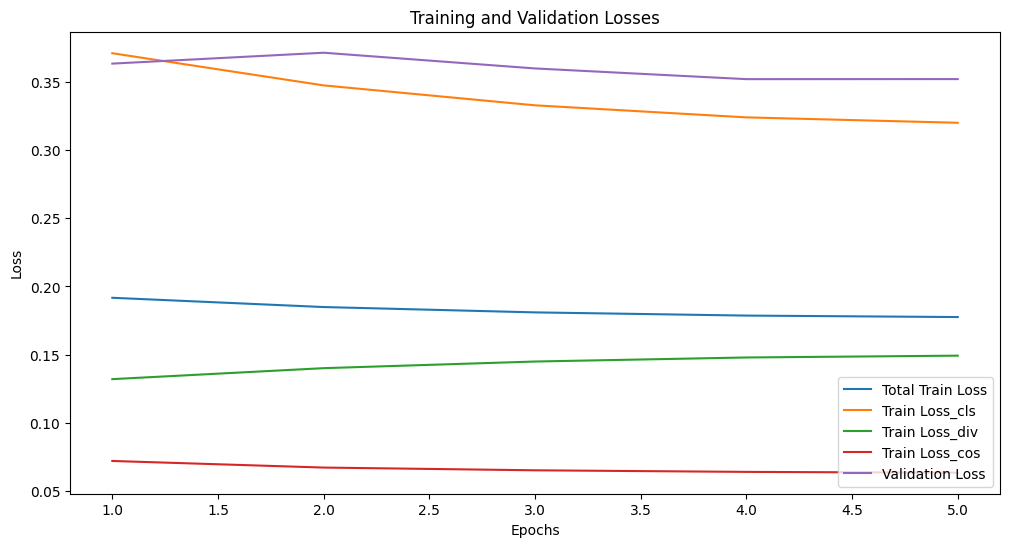

In [38]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [39]:
import torch
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
eval_metrics = 0

# Lists to store losses for each epoch
train_losses = []
train_losses_cls = []
train_losses_div = []
train_losses_cos = []
eval_losses = []

for epoch in range(num_epochs):
    model_odd.train()
    teacher_model.eval()
    train_loss = 0
    train_loss_cls = 0
    train_loss_div = 0
    train_loss_cos = 0
    
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # compute student output
        outputs = model_odd(**batch) 
        # compute teacher output
        with torch.no_grad():
            output_teacher = teacher_model(**batch)

        # assert size
        assert outputs.logits.size() == output_teacher.logits.size()
        
        # cls loss 
        loss_cls  = outputs.loss
        train_loss_cls += loss_cls.item()
        # distillation loss
        loss_div = criterion_div(outputs.logits, output_teacher.logits)
        train_loss_div += loss_div.item()
        # cosine loss
        loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
        train_loss_cos += loss_cos.item()
        
        # Average the loss and return it
        loss = (loss_cls + loss_div + loss_cos) / 3
        
        train_loss += loss.item()
        loss.backward()
        # accelerator.backward(loss)
        # Step with optimizer
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
    train_losses.append(train_loss / len(train_dataloader))
    train_losses_cls.append(train_loss_cls / len(train_dataloader))
    train_losses_div.append(train_loss_div / len(train_dataloader))
    train_losses_cos.append(train_loss_cos / len(train_dataloader))

    print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
    print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
    print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
    
    model_odd.eval()
    eval_loss = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model_even(**batch)
            
        loss_cls = outputs.loss
        predictions = outputs.logits.argmax(dim=-1)

        eval_loss += loss_cls.item()
        # predictions, references = accelerator.gather((predictions, batch["labels"]))
        metric.add_batch(
            predictions=predictions, 
            references=batch["labels"])
        
    eval_metric = metric.compute()
    eval_metrics += eval_metric['accuracy'] 
    eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
    
    print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
print('Avg Metric', eval_metrics/num_epochs)

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch at 1: Train loss 0.1771:
  - Loss_cls: 0.3186
  - Loss_div: 0.1497
  - Loss_cos: 0.0630
Epoch at 1: Test Acc 0.9590
Epoch at 2: Train loss 0.1771:
  - Loss_cls: 0.3186
  - Loss_div: 0.1496
  - Loss_cos: 0.0630
Epoch at 2: Test Acc 0.9590
Epoch at 3: Train loss 0.1771:
  - Loss_cls: 0.3186
  - Loss_div: 0.1496
  - Loss_cos: 0.0630
Epoch at 3: Test Acc 0.9590
Epoch at 4: Train loss 0.1771:
  - Loss_cls: 0.3187
  - Loss_div: 0.1496
  - Loss_cos: 0.0630
Epoch at 4: Test Acc 0.9590
Epoch at 5: Train loss 0.1771:
  - Loss_cls: 0.3186
  - Loss_div: 0.1497
  - Loss_cos: 0.0630
Epoch at 5: Test Acc 0.9590
Avg Metric 0.959


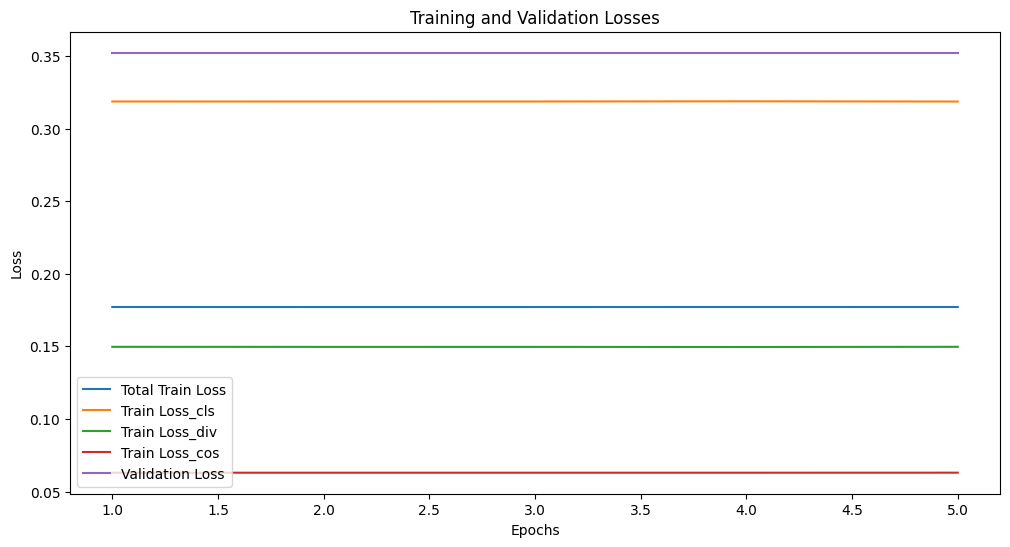

In [40]:
import matplotlib.pyplot as plt
# Plotting
epochs_list = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Total Train Loss')
plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
plt.plot(epochs_list, eval_losses, label='Validation Loss')

plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Appendix (Teacher Model)

In [41]:
# import torch
# from tqdm.auto import tqdm
# import torch.optim as optim
# import torch.nn as nn

# lr = 5e-5
# #training hyperparameters
# optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

# progress_bar = tqdm(range(num_training_steps))
# eval_metrics = 0

# for epoch in range(num_epochs):
#     teacher_model.train()
#     train_loss = 0
#     for step, batch in enumerate(train_dataloader):
#         batch = {k: v.to(device) for k, v in batch.items()}
#         output_teacher = teacher_model(**batch)
#         # cls loss 
#         loss = output_teacher.loss
#         train_loss += loss.item()
#         loss.backward()
#         # accelerator.backward(loss)
#         # Step with optimizer
#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

#     print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
#     teacher_model.eval()
#     for step, batch in enumerate(eval_dataloader):
#         batch = {k: v.to(device) for k, v in batch.items()}
#         with torch.no_grad():
#             outputs = teacher_model(**batch)
    
#         predictions = outputs.logits.argmax(dim=-1)
#         # predictions, references = accelerator.gather((predictions, batch["labels"]))
#         metric.add_batch(
#             predictions=predictions, 
#             references=batch["labels"])
        
#     eval_metric = metric.compute()
#     eval_metrics += eval_metric['accuracy'] 
#     print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
# print('Avg Metric', eval_metrics/num_epochs)

In [ ]:
model_odd.save_pretrained("bert_model_odd")